In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import cv2
import os
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr

# Helper function to display images in Jupyter
def show_image(image, title='', cmap=None, figsize=(5, 5)):
    """Helper function to display an image in a Jupyter Notebook."""
    plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        # OpenCV loads as BGR, but Matplotlib displays as RGB
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- WATERMARK EMBEDDING CLASS (COLOR) ---

class SemiFragileDWTWatermark:
    def __init__(self, wavelet='haar', quant_step=20):
        self.wavelet = wavelet
        self.quant_step = quant_step
        print(f"Color Watermarker initialized (Wavelet: {self.wavelet}, Q-Step: {self.quant_step})")

    def _embed_bit(self, coeff, bit):
        quantized = np.round(coeff / self.quant_step)
        if bit == 0 and quantized % 2 != 0:
            quantized -= 1
        elif bit == 1 and quantized % 2 == 0:
            quantized += 1
        return quantized * self.quant_step

    def embed_watermark(self, image_path, watermark_key, output_path='watermarked_image.png'):
        # --- 1. Load and Prepare Image (in COLOR) ---
        host_image_color = cv2.imread(image_path) # Load BGR image
        if host_image_color is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        
        original_shape = host_image_color.shape
        
        # --- 2. Convert to YCbCr and Split Channels ---
        host_image_ycbcr = cv2.cvtColor(host_image_color, cv2.COLOR_BGR2YCrCb)
        y_channel, cr_channel, cb_channel = cv2.split(host_image_ycbcr)
        
        # We will ONLY watermark the Y (Luminance) channel
        host_image = y_channel.astype(np.float64)
        
        # --- 3. Perform DWT on Y-Channel ---
        coeffs = pywt.dwt2(host_image, self.wavelet)
        cA, (cH, cV, cD) = coeffs
        
        # --- 4. Generate Watermark ---
        watermark_shape = cH.shape
        np.random.seed(watermark_key)
        watermark = np.random.randint(0, 2, size=watermark_shape)
        
        # --- 5. Embed Watermark in Y-Channel Sub-bands ---
        cH_w, cV_w = cH.copy(), cV.copy()
        for i in range(watermark_shape[0]):
            for j in range(watermark_shape[1]):
                bit_to_embed = watermark[i, j]
                cH_w[i, j] = self._embed_bit(cH_w[i, j], bit_to_embed)
                cV_w[i, j] = self._embed_bit(cV_w[i, j], bit_to_embed)
        
        # --- 6. Reconstruct Y-Channel ---
        watermarked_coeffs = cA, (cH_w, cV_w, cD)
        watermarked_y_channel_f = pywt.idwt2(watermarked_coeffs, self.wavelet)
        
        # Ensure output is same size as input Y-channel
        watermarked_y_channel_f = watermarked_y_channel_f[:original_shape[0], :original_shape[1]]
        
        # Clip and convert Y-channel
        watermarked_y_channel = np.clip(watermarked_y_channel_f, 0, 255).astype(np.uint8)
        
        # --- 7. Merge Watermarked Y with Original Cb/Cr ---
        watermarked_ycbcr = cv2.merge([watermarked_y_channel, cr_channel, cb_channel])
        
        # --- 8. Convert back to BGR ---
        watermarked_image_color = cv2.cvtColor(watermarked_ycbcr, cv2.COLOR_YCrCb2BGR)
        
        cv2.imwrite(output_path, watermarked_image_color)
        
        # Calculate PSNR on the full color images
        p = psnr(host_image_color, watermarked_image_color)
        print(f"Color watermark embedded (PSNR: {p:.2f} dB). Saved to: {output_path}")

        return watermarked_image_color, watermark

# --- TAMPER DETECTION CLASS (COLOR) ---

class TamperDetector:
    def __init__(self, wavelet='haar', quant_step=20):
        self.wavelet = wavelet
        self.quant_step = quant_step

    def _extract_bit(self, coeff):
        quantized = np.round(coeff / self.quant_step)
        return 0 if quantized % 2 == 0 else 1

    def detect_tampering(self, image_path, original_watermark):
        # --- 1. Load and Prepare Image (in COLOR) ---
        test_image_color = cv2.imread(image_path)
        if test_image_color is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        
        # --- 2. Convert to YCbCr and Split ---
        try:
            test_image_ycbcr = cv2.cvtColor(test_image_color, cv2.COLOR_BGR2YCrCb)
            y_channel, _, _ = cv2.split(test_image_ycbcr)
        except cv2.error as e:
            print(f"Error processing image (likely corrupted or wrong format): {e}")
            return np.ones_like(original_watermark), 100.0

        # We only need to check the Y channel
        test_image = y_channel.astype(np.float64)
        
        # --- 3. Perform DWT on Y-Channel ---
        try:
            coeffs = pywt.dwt2(test_image, self.wavelet)
        except ValueError as e:
            print(f"Error during DWT: {e}. Image dimensions may be invalid.")
            return np.ones_like(original_watermark), 100.0

        cA, (cH, cV, cD) = coeffs
        
        # --- 4. Extract and Compare Watermark (Same as before) ---
        h, w = original_watermark.shape
        if cH.shape[0] < h or cH.shape[1] < w:
            print("Warning: Image appears cropped. Detecting tampering on remaining area.")
            tamper_map = np.ones((h, w), dtype=np.uint8)
            h_test, w_test = cH.shape
            
            for i in range(h_test):
                for j in range(w_test):
                    bit_h = self._extract_bit(cH[i, j])
                    bit_v = self._extract_bit(cV[i, j])
                    original_bit = original_watermark[i, j]
                    error = (bit_h != original_bit) | (bit_v != original_bit)
                    tamper_map[i, j] = 1 if error else 0
        else:
            tamper_map = np.zeros((h, w), dtype=np.uint8)
            for i in range(h):
                for j in range(w):
                    bit_h = self._extract_bit(cH[i, j])
                    bit_v = self._extract_bit(cV[i, j])
                    original_bit = original_watermark[i, j]
                    error = (bit_h != original_bit) | (bit_v != original_bit)
                    tamper_map[i, j] = 1 if error else 0
        
        tamper_percentage = np.sum(tamper_map) / tamper_map.size * 100
        return tamper_map, tamper_percentage

    def visualize_tamper_map(self, original_image_path, tamper_map):
        """
        This function DOES NOT need any changes, as it was already
        loading the original image in color to create the overlay.
        """
        original_image = cv2.imread(original_image_path)
        if original_image is None:
            raise FileNotFoundError(f"Image not found at {original_image_path}")

        tamper_map_resized = cv2.resize(
            tamper_map, 
            (original_image.shape[1], original_image.shape[0]), 
            interpolation=cv2.INTER_NEAREST
        )
        
        tamper_map_color = np.zeros_like(original_image)
        tamper_map_color[tamper_map_resized == 1] = [0, 0, 255] # Red (BGR)
        
        overlay = cv2.addWeighted(original_image, 0.4, tamper_map_color, 0.6, 0)
        
        show_image(overlay, title='Tamper Map Overlay (Red = Tampered)')

'wget' is not recognized as an internal or external command,
operable program or batch file.


--- Embedding Color Watermark ---
Color Watermarker initialized (Wavelet: db1, Q-Step: 30)
Color watermark embedded (PSNR: 24.41 dB). Saved to: lena_watermarked_color.png


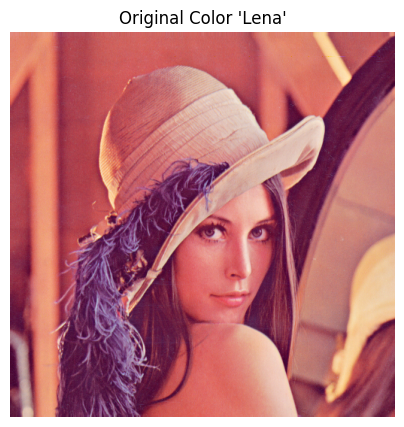

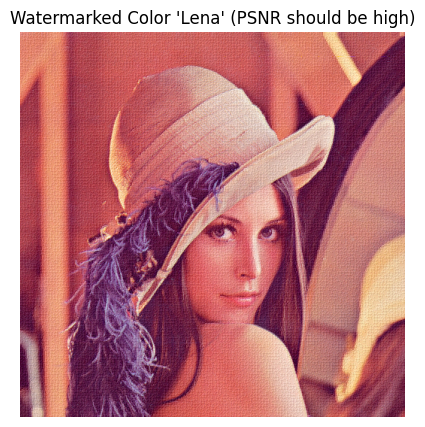

In [2]:
# Download Lena (if not already present)
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg -O lena.jpg

# --- Parameters ---
TEST_IMAGE = 'lena.jpg'
WATERMARKED_IMAGE = 'lena_watermarked_color.png'
QUANTIZATION_STEP = 30
WATERMARK_KEY = 12345 

# --- Embed Watermark ---
print("--- Embedding Color Watermark ---")
embedder = SemiFragileDWTWatermark(wavelet='db1', quant_step=QUANTIZATION_STEP)
watermarked_img, original_watermark = embedder.embed_watermark(
    image_path=TEST_IMAGE, 
    watermark_key=WATERMARK_KEY,
    output_path=WATERMARKED_IMAGE
)

# --- Show Results ---
show_image(cv2.imread(TEST_IMAGE), title="Original Color 'Lena'")
show_image(watermarked_img, title="Watermarked Color 'Lena' (PSNR should be high)")

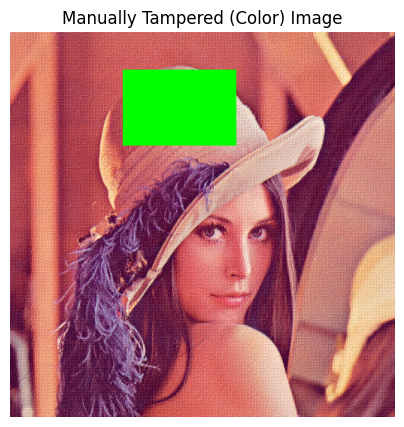

In [3]:
# Load the watermarked COLOR image
tampered_img_color = cv2.imread(WATERMARKED_IMAGE)

# Draw a bright green rectangle on it
cv2.rectangle(tampered_img_color, (150, 50), (300, 150), (0, 255, 0), -1) # BGR green

tampered_path_color = 'lena_tampered_color.png'
cv2.imwrite(tampered_path_color, tampered_img_color)

# Show the tampered image
show_image(tampered_img_color, title='Manually Tampered (Color) Image')


--- Checking Tampered Color Image ---
✅ RESULT: Tampering detected! (3.00%)


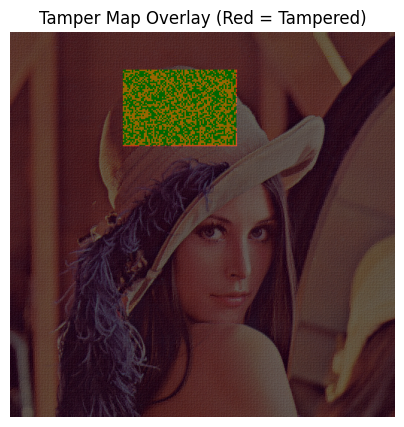

In [4]:
# --- Run the detector ---
print("\n--- Checking Tampered Color Image ---")
detector = TamperDetector(wavelet='db1', quant_step=QUANTIZATION_STEP)
tamper_map, percentage = detector.detect_tampering(tampered_path_color, original_watermark)

if percentage > 0:
    print(f"✅ RESULT: Tampering detected! ({percentage:.2f}%)")
    # Visualize exactly WHERE the tampering occurred
    detector.visualize_tamper_map(tampered_path_color, tamper_map)
else:
    print("❌ RESULT: No tampering detected.")